# Analysis of Abl mutations in Perses

Analysis of the Hauser et al. mutations for dasatinib and imatinib inhibitors

**Note:** Some simulations are still running for a number of mutations and so the dataset may be incomplete.

In [5]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import notebook as tqdm_notebook
import pandas as pd


from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [1]:
def subtract_offset(forward_work, reverse_work):

    print("--> subtracting offset")
    
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)
    
    return forward_work_offset, reverse_work_offset

In [2]:
def analyse(forward_accumulated, reverse_accumulated):
    
    print("--> computing dg, ddg")
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    
    return dg, ddg


In [3]:
def plot_works(forward_work_offset,
               reverse_work_offset,
               dg,
               ddg,
               phase,
               mutation,
               title,
               save=False,
               output_dir=None):
    
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    
    # Plot work trajectories
    # TODO: automatically determine the x axis -> this is a bit of a hack at the moment
    print("--> plotting work trajs")
    
    for i, cycle in enumerate(forward_work_offset):
        
        x = [(j+1)*12.1e-4 for j in range(len(list(cycle)))]
        y = cycle
        if i==0:
            plt.plot(x, y, color=CB_color_cycle[0], label='forward')
        else:
            plt.plot(x, y, color=CB_color_cycle[0])
        
    for i, cycle in enumerate(reverse_work_offset):
        
        x = [(j+1)*12.1e-4 for j in range(len(list(cycle)))]
        y = -cycle
        if i==0:
            plt.plot(x, y, color=CB_color_cycle[1], label='reverse')
        else:
            plt.plot(x, y, color=CB_color_cycle[1])
        
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.legend(loc='best')
    if save:
        if output_dir is not None:
            plt.savefig(os.path.join(output_dir, f"{mutation}_{phase}_work_traj.png"), dpi=500)
            print(f"--> saved to: {os.path.join(output_dir, f'{mutation}_{phase}_work_traj.png')}")
        else:
            print("--> No output_dir specified!")
    else:
        plt.show()
    plt.clf()
    
    # Plot work distributions
    print("--> plotting work distrib")
    
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward, color=CB_color_cycle[0], label='forward')
    sns.distplot(accumulated_reverse, color=CB_color_cycle[1], label='reverse')
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.legend(loc='best')
    if save:
        if output_dir is not None:
            plt.savefig(os.path.join(output_dir, f"{mutation}_{phase}_work_dist.png"), dpi=500)
            print(f"--> saved to: {os.path.join(output_dir, f'{mutation}_{phase}_work_dist.png')}")
        else:
            print("--> No output_dir specified!")
    else:
        plt.show()
    plt.clf()

In [4]:
# 4xey dasatinib mutations
dasatinib_mutations = [
    'E255K', 'E255V', 'E355A', 'F317C', 'F317I',
    'F317L', 'F317V', 'F359C', 'F359I', 'F359V',
    'G250E', 'H396R', 'L248R', 'L248V', 'M244V',
    'M351T', 'T315A', 'T315I', 'V299L', 'Y253F'
    ]

# 2hyy imatinib mutations
imatinib_mutations = [
    'M244V', 'L248R', 'L248V', 'G250E', 'Y253F',
    'E255K', 'E255V', 'V299L', 'T315A', 'T315I',
    'F317C', 'F317I', 'F317L', 'F317V', 'M351T',
    'E355A', 'F359C', 'F359I', 'F359V', 'H396R',
    'E459K'
]

In [12]:
tki = 'dasatinib'
pdb_code = '4xey'
sim_df_dasatinib = {}

for mutation in dasatinib_mutations:

    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []

    for j in tqdm_notebook.tqdm(range(100)):

        # Note: dasatinib runs contain no trajectory [WIP]
        forward_complex_path = f'/data/chodera/glassw/kinoml/Abl/Hauser_mutations/run_neq_NoTraj/{pdb_code}/{mutation}/{pdb_code}_{tki}_{mutation}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/glassw/kinoml/Abl/Hauser_mutations/run_neq_NoTraj/{pdb_code}/{mutation}/{pdb_code}_{tki}_{mutation}_complex_{j}_reverse.npy'
        forward_apo_path = f'/data/chodera/glassw/kinoml/Abl/Hauser_mutations/run_neq_NoTraj/{pdb_code}/{mutation}/{pdb_code}_{tki}_{mutation}_apo_{j}_forward.npy'
        reverse_apo_path = f'/data/chodera/glassw/kinoml/Abl/Hauser_mutations/run_neq_NoTraj/{pdb_code}/{mutation}/{pdb_code}_{tki}_{mutation}_apo_{j}_reverse.npy'

        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                forward_complex_arrays.append(np.load(f))

        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                reverse_complex_arrays.append(np.load(f))

        if os.path.exists(forward_apo_path):
            with open(forward_apo_path, 'rb') as f:
                forward_apo_arrays.append(np.load(f))

        if os.path.exists(reverse_apo_path):
            with open(reverse_apo_path, 'rb') as f:
                reverse_apo_arrays.append(np.load(f))

    if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:

        forward_complex_combined = np.concatenate(forward_complex_arrays)
        forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
        forward_complex_combined = np.array([cycle for cycle in forward_complex_combined])
        print(forward_complex_combined.shape)

        reverse_complex_combined = np.concatenate(reverse_complex_arrays)
        reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        reverse_complex_combined = np.array([cycle for cycle in reverse_complex_combined])

        forward_apo_combined = np.concatenate(forward_apo_arrays)
        forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])
        forward_apo_combined = np.array([cycle for cycle in forward_apo_combined])
        print(forward_apo_combined.shape)

        reverse_apo_combined = np.concatenate(reverse_apo_arrays)
        reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])
        reverse_apo_combined = np.array([cycle for cycle in reverse_apo_combined])


        # Analyse

        ## complex
        forward_complex_work_offset, reverse_complex_work_offset = subtract_offset(forward_complex_combined,
                                                                                   reverse_complex_combined)

        complex_dg, complex_ddg = analyse(forward_complex_accumulated,
                                          reverse_complex_accumulated)

        ## apo
        forward_apo_work_offset, reverse_apo_work_offset = subtract_offset(forward_apo_combined,
                                                                           reverse_apo_combined)

        apo_dg, apo_ddg = analyse(forward_apo_accumulated, reverse_apo_accumulated)

        ## plot the work trajectories and distibutions
        complex_plot = plot_works(forward_complex_work_offset,
                                  reverse_complex_work_offset,
                                  complex_dg,
                                  complex_ddg,
                                  phase='complex',
                                  mutation=mutation,
                                  title=f'{pdb_code.upper()}-{tki} {mutation}',
                                  save=True,
                                  output_dir=f'/lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/{tki}')

        apo_plot = plot_works(forward_apo_work_offset,
                              reverse_apo_work_offset,
                              apo_dg,
                              apo_ddg,
                              phase='apo',
                              mutation=mutation,
                              title=f'{pdb_code.upper()}-{tki} {mutation}',
                              save=True,
                              output_dir=f'/lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/{tki}')

        ## Get binding dg and ddg
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        sim_df_dasatinib[mutation] = [binding_dg, binding_ddg]
        print(f"--> complex_dg: {complex_dg}")
        print(f"--> apo dg: {apo_dg}")

    else:
        print(f"--> dir {mutation} has at least one phase without data" )


(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E255K_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E255K_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E255K_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E255K_apo_work_dist.png
--> complex_dg: 88.13278887022689
--> apo dg: 87.780638683229



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E255V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E255V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E255V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E255V_apo_work_dist.png
--> complex_dg: 167.51061087390414
--> apo dg: 166.40491329537141



(96, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E355A_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E355A_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E355A_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/E355A_apo_work_dist.png
--> complex_dg: 144.22325183167385
--> apo dg: 144.43374962832823



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317C_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317C_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317C_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317C_apo_work_dist.png
--> complex_dg: 25.796888742392305
--> apo dg: 23.160259820482068



(100, 1251)
(96, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317I_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317I_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317I_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317I_apo_work_dist.png
--> complex_dg: 27.700176516508524
--> apo dg: 24.355188621712536



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317L_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317L_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317L_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317L_apo_work_dist.png
--> complex_dg: 22.496068635091927
--> apo dg: 16.612852752236112



(94, 1251)
(85, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F317V_apo_work_dist.png
--> complex_dg: 45.93668684846123
--> apo dg: 42.37123555759635



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359C_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359C_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359C_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359C_apo_work_dist.png
--> complex_dg: 18.383535953946843
--> apo dg: 18.054830119185425



(96, 1251)
(96, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359I_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359I_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359I_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359I_apo_work_dist.png
--> complex_dg: 23.868517836618352
--> apo dg: 23.326503167934817



(79, 1251)
(83, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/F359V_apo_work_dist.png
--> complex_dg: 42.849051906935415
--> apo dg: 42.25824562961964



(100, 1251)
(98, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/G250E_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/G250E_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/G250E_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/G250E_apo_work_dist.png
--> complex_dg: -140.134425653294
--> apo dg: -140.14467150541165



--> dir H396R has at least one phase without data



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/L248R_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/L248R_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/L248R_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/L248R_apo_work_dist.png
--> complex_dg: 223.97787432349946
--> apo dg: 214.2589145572909



(99, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/L248V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/L248V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/L248V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/L248V_apo_work_dist.png
--> complex_dg: -3.6164771546441825
--> apo dg: -4.01772452984385



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/M244V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/M244V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/M244V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/M244V_apo_work_dist.png
--> complex_dg: 17.782103533197716
--> apo dg: 17.66686460262487



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/M351T_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/M351T_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/M351T_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/M351T_apo_work_dist.png
--> complex_dg: 38.27548994506478
--> apo dg: 38.2686007304109



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/T315A_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/T315A_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/T315A_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/T315A_apo_work_dist.png
--> complex_dg: -38.43916600968556
--> apo dg: -42.790856479421876



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/T315I_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/T315I_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/T315I_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/T315I_apo_work_dist.png
--> complex_dg: 22.389351804090488
--> apo dg: 17.762215768105488



(92, 1251)
(58, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/V299L_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/V299L_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/V299L_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/V299L_apo_work_dist.png
--> complex_dg: 8.464391603207996
--> apo dg: 6.107978948285946



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/Y253F_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/Y253F_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/Y253F_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/dasatinib/Y253F_apo_work_dist.png
--> complex_dg: -0.7192513584570825
--> apo dg: -1.7977034149970241


<Figure size 432x288 with 0 Axes>

In [7]:
tki = 'imatinib'
pdb_code = '2hyy'
sim_df_imatinib = {}
for mutation in imatinib_mutations:

    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []

    for j in tqdm_notebook.tqdm(range(100)):

        forward_complex_path = f'/data/chodera/glassw/kinoml/Abl/Hauser_mutations/run_neq_WithTraj/{pdb_code}/{mutation}/{pdb_code}_{tki}_{mutation}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/glassw/kinoml/Abl/Hauser_mutations/run_neq_WithTraj/{pdb_code}/{mutation}/{pdb_code}_{tki}_{mutation}_complex_{j}_reverse.npy'
        forward_apo_path = f'/data/chodera/glassw/kinoml/Abl/Hauser_mutations/run_neq_WithTraj/{pdb_code}/{mutation}/{pdb_code}_{tki}_{mutation}_apo_{j}_forward.npy'
        reverse_apo_path = f'/data/chodera/glassw/kinoml/Abl/Hauser_mutations/run_neq_WithTraj/{pdb_code}/{mutation}/{pdb_code}_{tki}_{mutation}_apo_{j}_reverse.npy'

        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                forward_complex_arrays.append(np.load(f))

        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                reverse_complex_arrays.append(np.load(f))

        if os.path.exists(forward_apo_path):
            with open(forward_apo_path, 'rb') as f:
                forward_apo_arrays.append(np.load(f))

        if os.path.exists(reverse_apo_path):
            with open(reverse_apo_path, 'rb') as f:
                reverse_apo_arrays.append(np.load(f))

    if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:

        forward_complex_combined = np.concatenate(forward_complex_arrays)
        forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
        forward_complex_combined = np.array([cycle for cycle in forward_complex_combined])
        print(forward_complex_combined.shape)

        reverse_complex_combined = np.concatenate(reverse_complex_arrays)
        reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        reverse_complex_combined = np.array([cycle for cycle in reverse_complex_combined])

        forward_apo_combined = np.concatenate(forward_apo_arrays)
        forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])
        forward_apo_combined = np.array([cycle for cycle in forward_apo_combined])
        print(forward_apo_combined.shape)

        reverse_apo_combined = np.concatenate(reverse_apo_arrays)
        reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])
        reverse_apo_combined = np.array([cycle for cycle in reverse_apo_combined])


        # Analyse

        ## complex
        forward_complex_work_offset, reverse_complex_work_offset = subtract_offset(forward_complex_combined,
                                                                                   reverse_complex_combined)

        complex_dg, complex_ddg = analyse(forward_complex_accumulated,
                                          reverse_complex_accumulated)

        ## apo
        forward_apo_work_offset, reverse_apo_work_offset = subtract_offset(forward_apo_combined,
                                                                           reverse_apo_combined)

        apo_dg, apo_ddg = analyse(forward_apo_accumulated, reverse_apo_accumulated)

        ## plot the work trajectories and distibutions
        complex_plot = plot_works(forward_complex_work_offset,
                                  reverse_complex_work_offset,
                                  complex_dg,
                                  complex_ddg,
                                  phase='complex',
                                  mutation=mutation,
                                  title=f'{pdb_code.upper()}-{tki} {mutation}',
                                  save=True,
                                  output_dir=f'/lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/{tki}')

        apo_plot = plot_works(forward_apo_work_offset,
                              reverse_apo_work_offset,
                              apo_dg,
                              apo_ddg,
                              phase='apo',
                              mutation=mutation,
                              title=f'{pdb_code.upper()}-{tki} {mutation}',
                              save=True,
                              output_dir=f'/lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/{tki}')

        ## Get binding dg and ddg
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        sim_df_imatinib[mutation] = [binding_dg, binding_ddg]
        print(f"--> complex_dg: {complex_dg}")
        print(f"--> apo dg: {apo_dg}")

    else:
        print(f"--> dir {mutation} has at least one phase without data" )


(98, 1251)
(92, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/M244V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/M244V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/M244V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/M244V_apo_work_dist.png
--> complex_dg: 16.955464368038232
--> apo dg: 17.692409055749348



(96, 1251)
(96, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/L248R_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/L248R_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/L248R_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/L248R_apo_work_dist.png
--> complex_dg: 216.06272702498163
--> apo dg: 212.70699023569264



(100, 1251)
(51, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/L248V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/L248V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/L248V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/L248V_apo_work_dist.png
--> complex_dg: -6.126462659470182
--> apo dg: -5.180664492335502



(77, 1251)
(63, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/G250E_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/G250E_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/G250E_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/G250E_apo_work_dist.png
--> complex_dg: -139.99941753268538
--> apo dg: -139.41791789419074



(59, 1251)
(66, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/Y253F_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/Y253F_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/Y253F_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/Y253F_apo_work_dist.png
--> complex_dg: -0.6236583048266383
--> apo dg: -1.3504533571733002



(65, 1251)
(63, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/E255K_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/E255K_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/E255K_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/E255K_apo_work_dist.png
--> complex_dg: 89.52463575128951
--> apo dg: 88.13562657912775



(67, 1251)
(55, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/E255V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/E255V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/E255V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/E255V_apo_work_dist.png
--> complex_dg: 168.13500233662083
--> apo dg: 166.39395170998486



(20, 1251)
(13, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/V299L_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/V299L_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/V299L_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/imatinib/V299L_apo_work_dist.png
--> complex_dg: 4.242183682131279
--> apo dg: 5.33514580672798



--> dir T315A has at least one phase without data



--> dir T315I has at least one phase without data



--> dir F317C has at least one phase without data



--> dir F317I has at least one phase without data



--> dir F317L has at least one phase without data



--> dir F317V has at least one phase without data



--> dir M351T has at least one phase without data



--> dir E355A has at least one phase without data



--> dir F359C has at least one phase without data



--> dir F359I has at least one phase without data



--> dir F359V has at least one phase without data



--> dir H396R has at least one phase without data



--> dir E459K has at least one phase without data


<Figure size 432x288 with 0 Axes>

Save and view the results

In [8]:
def save_csv(experimental_dataframe, simulation_dataframe, tki, pdb_code):
    # exp_df = pd.read_csv(experimental_dataframe)

    exp_df = experimental_dataframe[experimental_dataframe['tki'] == tki]

    sim_df = pd.DataFrame(simulation_dataframe).T
    sim_df = sim_df * KT_KCALMOL
    sim_df.columns = ["DDG (kcal / mol)", "dDDG (kcal / mol)"]
    
    # get the experimental values from the tki dataframe
    exp_DDG = [exp_df[exp_df['mutation'] == mutation]['ddG_exp'].item() 
            for mutation in list(sim_df.index)]

    sim_df['exp_DDG (kcal / mol)'] = exp_DDG 
    sim_df['|DDG - exp_DDG|'] = (sim_df['DDG (kcal / mol)'] - sim_df['exp_DDG (kcal / mol)']).abs()

    sim_df.to_csv(f'{pdb_code}_{tki}_DDGs.csv')

    return sim_df


In [9]:
exp_df = pd.read_csv('../data/hauser_mutations.csv')

In [13]:
df_4xey = save_csv(experimental_dataframe=exp_df, simulation_dataframe=sim_df_dasatinib, tki='dasatinib', pdb_code='4xey')

In [14]:
df_2hyy = save_csv(experimental_dataframe=exp_df, simulation_dataframe=sim_df_imatinib, tki='imatinib', pdb_code='2hyy')

## Plotting

taken from: https://github.com/openforcefield/Arsenic/blob/master/arsenic/plotting.py, credit: `@hannahbrucemacdonald`

In [15]:
import scipy
from sklearn.metrics import mean_squared_error, mean_absolute_error

def stats(true_sample, predicted_sample, statistic):
    
    if statistic == 'RMSE':
            return np.sqrt(mean_squared_error(true_sample, predicted_sample))
    elif statistic == 'MUE':
        return mean_absolute_error(true_sample, predicted_sample)
    elif statistic == 'R2':
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(true_sample, predicted_sample)
        return r_value**2
    elif statistic == 'rho':
        return scipy.stats.pearsonr(true_sample, predicted_sample)[0]

### Dasatinib

In [16]:
x = df_4xey['exp_DDG (kcal / mol)'].values
y = df_4xey['DDG (kcal / mol)'].values
yerr = df_4xey['dDDG (kcal / mol)'].values

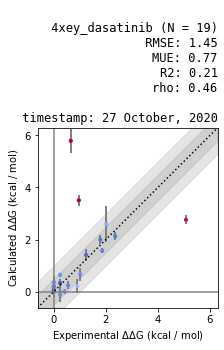

In [17]:
from datetime import date
today = date.today()
figsize=5

fig, ax = plt.subplots(figsize=(figsize, figsize))


# aesthetics
font_size = 14
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['font.size'] = font_size
plt.subplots_adjust(left=0.2, right=0.7, bottom=0.2, top=0.7)


plt.xlabel('Experimental $\Delta\Delta$G (kcal / mol)')
plt.ylabel(r'Calculated $\Delta\Delta$G (kcal / mol)')

ax_min = min(min(x), min(y)) - 0.5
ax_max = max(max(x), max(y)) + 0.5
scale = [ax_min, ax_max]

plt.xlim(scale)
plt.ylim(scale)

# plots x-axis and y-axis
origins=True
if origins:
    plt.plot([0, 0], scale, 'gray')
    plt.plot(scale, [0, 0], 'gray')

# plots x=y line
plt.plot(scale, scale, 'k:')
guidelines=True

if guidelines:
    small_dist = 0.5
    # plots grey region around x=y line
    plt.fill_between(scale, [ax_min - small_dist, ax_max - small_dist],
                     [ax_min + small_dist, ax_max + small_dist],
                     color='grey', alpha=0.2)
    plt.fill_between(scale, [ax_min - small_dist * 2, ax_max - small_dist * 2],
                     [ax_min + small_dist * 2, ax_max + small_dist * 2],
                     color='grey', alpha=0.2)
# actual plotting
cm = plt.get_cmap('coolwarm')

#if color is None:
color = np.abs(x-y)
# 2.372 kcal / mol = 4 RT
color = cm(color / 2.372)

plt.errorbar(x, y, yerr=yerr, color='gray', linewidth=0., elinewidth=2., zorder=1)
plt.scatter(x, y, color=color, s=10, marker='o', zorder=2)

# stats and title
statistics_string = ''
for statistic in ['RMSE', 'MUE', 'R2', 'rho']:
    s = np.round(stats(x, y, statistic=statistic), 2)
    string = f"{statistic}: {s}\n"
    statistics_string += string

title = ''
target_name = '4xey_dasatinib'
long_title = f'{title} \n {target_name} (N = {len(y)})\n {statistics_string} \n timestamp: {today.strftime("%d %B, %Y")}'
plt.title(long_title, fontsize=12, loc='right', horizontalalignment='right', family='monospace')


plt.savefig('4xey_dasatinib_exp_vs_calc.png', dpi=300)

### Imatinib

In [18]:
x = df_2hyy['exp_DDG (kcal / mol)'].values
y = df_2hyy['DDG (kcal / mol)'].values
yerr = df_2hyy['dDDG (kcal / mol)'].values

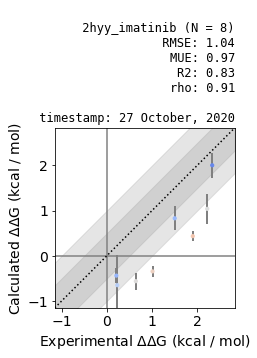

In [19]:
from datetime import date
today = date.today()
figsize=5

fig, ax = plt.subplots(figsize=(figsize, figsize))


# aesthetics
font_size = 14
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['font.size'] = font_size
plt.subplots_adjust(left=0.2, right=0.7, bottom=0.2, top=0.7)


plt.xlabel('Experimental $\Delta\Delta$G (kcal / mol)')
plt.ylabel(r'Calculated $\Delta\Delta$G (kcal / mol)')

ax_min = min(min(x), min(y)) - 0.5
ax_max = max(max(x), max(y)) + 0.5
scale = [ax_min, ax_max]

plt.xlim(scale)
plt.ylim(scale)

# plots x-axis and y-axis
origins=True
if origins:
    plt.plot([0, 0], scale, 'gray')
    plt.plot(scale, [0, 0], 'gray')

# plots x=y line
plt.plot(scale, scale, 'k:')
guidelines=True

if guidelines:
    small_dist = 0.5
    # plots grey region around x=y line
    plt.fill_between(scale, [ax_min - small_dist, ax_max - small_dist],
                     [ax_min + small_dist, ax_max + small_dist],
                     color='grey', alpha=0.2)
    plt.fill_between(scale, [ax_min - small_dist * 2, ax_max - small_dist * 2],
                     [ax_min + small_dist * 2, ax_max + small_dist * 2],
                     color='grey', alpha=0.2)
# actual plotting
cm = plt.get_cmap('coolwarm')

#if color is None:
color = np.abs(x-y)
# 2.372 kcal / mol = 4 RT
color = cm(color / 2.372)

plt.errorbar(x, y, yerr=yerr, color='gray', linewidth=0., elinewidth=2., zorder=1)
plt.scatter(x, y, color=color, s=10, marker='o', zorder=2)

# stats and title
statistics_string = ''
for statistic in ['RMSE', 'MUE', 'R2', 'rho']:
    s = np.round(stats(x, y, statistic=statistic), 2)
    string = f"{statistic}: {s}\n"
    statistics_string += string

title = ''
target_name = '2hyy_imatinib'
long_title = f'{title} \n {target_name} (N = {len(y)})\n {statistics_string} \n timestamp: {today.strftime("%d %B, %Y")}'
plt.title(long_title, fontsize=12, loc='right', horizontalalignment='right', family='monospace')


plt.savefig('2hyy_imatinib_exp_vs_calc.png', dpi=300)